In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import urllib.request
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.losses import MeanAbsoluteError
from sklearn.preprocessing import MinMaxScaler

In [20]:
!pip install stellargraph #will be already installed if running on a local virtual environment. Necessary if using google colab
import stellargraph as sg


In [4]:
#Uncomment this file if using google colab to import dataset.


#from google.colab import files
#uploaded = files.upload()

Saving ebdataset.csv to ebdataset.csv


In [21]:
dataset = pd.read_csv("clean_data/ebdataset.csv")
dataset.drop(['Time','Date'], axis = 1, inplace = True)
corrmatrix = dataset.corr() 

corrmatrix.style.background_gradient(cmap='coolwarm',vmin = -1, vmax = 1).set_precision(2)


,010Volume,010Speed,032Volume,032Speed,045Volume,045Speed,061Volume,061Speed
010Volume,1.00,0.00,0.74,-0.36,0.81,-0.25,0.67,-0.26
010Speed,0.00,1.00,0.03,0.14,0.05,0.04,0.01,0.01
032Volume,0.74,0.03,1.00,-0.27,0.89,-0.23,0.73,-0.26
032Speed,-0.36,0.14,-0.27,1.00,-0.38,0.40,-0.48,0.21
045Volume,0.81,0.05,0.89,-0.38,1.00,-0.26,0.79,-0.27
045Speed,-0.25,0.04,-0.23,0.40,-0.26,1.00,-0.30,0.21
061Volume,0.67,0.01,0.73,-0.48,0.79,-0.30,1.00,-0.29
061Speed,-0.26,0.01,-0.26,0.21,-0.27,0.21,-0.29,1.00


In [22]:
corrmatrix.to_csv('model_performances/ebcorrmatrix.csv')

In [23]:
#checking that gpu acceleration is functioning. If it is not, import to google colab

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [24]:

min_max_scaler = MinMaxScaler()#saving sklearns minmaxscaler as an object so it can be used to reverse any transformations later
scaled_dataset = pd.DataFrame(min_max_scaler.fit_transform(dataset))#scaling each column of the dataset so that all values are between 0 and 1

In [25]:
print(dataset.head())
print(scaled_dataset.head())#testing transformation was sucessful

   010Volume  010Speed  032Volume  ...  045Speed  061Volume  061Speed
0         90      90.0         36  ...      99.0         23      96.0
1         50      96.0         31  ...      99.0         14     100.0
2         74      93.0         43  ...     101.0         24      97.0
3         52      95.0         55  ...      96.0         19     100.0
4         66      92.0         38  ...      97.0         21      97.0

[5 rows x 8 columns]
          0         1         2  ...         5         6         7
0  0.274390  0.452632  0.130435  ...  0.569343  0.186992  0.568862
1  0.152439  0.484211  0.112319  ...  0.569343  0.113821  0.592814
2  0.225610  0.468421  0.155797  ...  0.583942  0.195122  0.574850
3  0.158537  0.478947  0.199275  ...  0.547445  0.154472  0.592814
4  0.201220  0.463158  0.137681  ...  0.554745  0.170732  0.574850

[5 rows x 8 columns]


In [26]:
#This function is taken from the StellarGraph documentation https://stellargraph.readthedocs.io/en/stable/demos/time-series/gcn-lstm-time-series.html
#Annotation provided by Bradley King 
#Modified to support time scale on the verticle axis instead of horizontal, transposes results to timescale on horizontal axis to support model format
#Modified to include a validation split as well as training/testing splits

train_split = 0.7 #portion of data for training
val_split = .15   #portion of data for testing
def split_time_data(data,train_portion,val_portion): # function for splitting data. recieves arugments for data, portion for training and portion for validation
    time_scale = data.shape[0]
    train_length = int(time_scale * train_portion)
    train_data=np.array(data.iloc[ :train_length,:])
    train_data_t = train_data.transpose()
    val_length = int(time_scale*val_portion)
    val_data = np.array(data.iloc[train_length:train_length+val_length,:])
    val_data_t = val_data.transpose()
    test_data=np.array(data.iloc[ train_length+val_length:,:])
    test_data_t=test_data.transpose()
    return train_data, val_data, test_data,train_data_t,val_data_t,test_data_t # returns training split, validation split, testing split and transposed versions of each split to suit model formatting requirements downstream


train_data,val_data, test_data,train_data_t,val_data_t,test_data_t = split_time_data(scaled_dataset, train_split,val_split)


In [27]:
#checking data shapes and formatting 

print(dataset.shape)

print("Train data:", train_data.shape)
print("Val data:", val_data.shape)
print("Test data:", test_data.shape)
print("Train data transposed:", train_data_t.shape)
print("Val data transposed:", val_data_t.shape)
print("Test data transposed:", test_data_t.shape)

(80640, 8)
Train data: (56448, 8)
Val data: (12096, 8)
Test data: (12096, 8)
Train data transposed: (8, 56448)
Val data transposed: (8, 12096)
Test data transposed: (8, 12096)


In [28]:
seq_len = 10 #length of data used for the prediction, currently using the last 10 mins of data
pre_len = 30 # distance of prediction, currently predicting speeds and volumes 30 mins from now

#This function is taken from the StellarGraph documentation https://stellargraph.readthedocs.io/en/stable/demos/time-series/gcn-lstm-time-series.html
#Annotation provided by Bradley King 
#Function modified to accept validation splits as well as training and testing
def sequence_data_preparation(seq_len, pre_len, train_data, val_data, test_data):
    trainX, trainY, valX,valY,testX, testY = [], [], [], [],[],[]

    for i in range(train_data.shape[1] - int(seq_len + pre_len - 1)):
        a = train_data[:, i : i + seq_len + pre_len] # grabbing a slice of the datafrom from time - sequence length to time + prediction length
        trainX.append(a[:, :seq_len]) # grab the first 10 columns, this is the prediction data
        trainY.append(a[:, -1]) # grab the last column in the slice, this is the target data

    for i in range(val_data.shape[1] - int(seq_len + pre_len - 1)):
        c = val_data[:, i : i + seq_len + pre_len] # grabbing a slice of the datafrom from time - sequence length to time + prediction length
        valX.append(c[:, :seq_len]) # grab the first 10 columns, this is the prediction data
        valY.append(c[:, -1]) # grab the last column in the slice, this is the target data

    # do the same process for the test data
    for i in range(test_data.shape[1] - int(seq_len + pre_len - 1)):
        b = test_data[:, i : i + seq_len + pre_len]
        testX.append(b[:, :seq_len])
        testY.append(b[:, -1])
    #when appending use lists, its easier computationally. Convert to numpy array at the end
    trainX = np.array(trainX) 
    trainY = np.array(trainY)
    valX = np.array(valX)
    valY=np.array(valY)
    testX = np.array(testX)
    testY = np.array(testY)

    return trainX, trainY, valX,valY, testX, testY

In [29]:
trainX, trainY,valX,valY, testX, testY = sequence_data_preparation(
    seq_len, pre_len, train_data_t, val_data_t,test_data_t) #creating model features and target attributes

#testing feature shapes
print(trainX.shape)
print(trainY.shape)
print(valX.shape)
print(valY.shape)
print(testX.shape)
print(testY.shape)

(56409, 8, 10)
(56409, 8)
(12057, 8, 10)
(12057, 8)
(12057, 8, 10)
(12057, 8)


In [30]:
from stellargraph.layer import GCN_LSTM


In [31]:

optimizer2=keras.optimizers.Adam(learning_rate=.01) #optimal validation loss occured at learning rate = 0.1
gcn_lstm = GCN_LSTM(
    seq_len=seq_len,
    adj=corrmatrix,
    gc_layer_sizes=[16, 10],
    gc_activations=["relu", "relu"],
    lstm_layer_sizes=[200, 200],
    lstm_activations=["tanh", "tanh"],
    )
x_input, x_output = gcn_lstm.in_out_tensors()

model = Model(inputs=x_input, outputs=x_output)
model.compile(optimizer=optimizer2, loss="mae", metrics=["mse"])
history = model.fit(
    trainX,
    trainY,
    epochs=150,
    batch_size=200,
    shuffle=True,
    verbose=1,
    validation_data=(valX, valY),
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  if __name__ == '__main__':


Epoch 1/150
283/283 [==============================] - 9s 20ms/step - loss: 0.0601 - mse: 0.0096 - val_loss: 0.0501 - val_mse: 0.0073
Epoch 2/150
283/283 [==============================] - 5s 16ms/step - loss: 0.0494 - mse: 0.0065 - val_loss: 0.0497 - val_mse: 0.0070
Epoch 3/150
283/283 [==============================] - 5s 16ms/step - loss: 0.0484 - mse: 0.0062 - val_loss: 0.0495 - val_mse: 0.0070
Epoch 4/150
283/283 [==============================] - 5s 16ms/step - loss: 0.0477 - mse: 0.0061 - val_loss: 0.0580 - val_mse: 0.0079
Epoch 5/150
283/283 [==============================] - 5s 16ms/step - loss: 0.0474 - mse: 0.0059 - val_loss: 0.0488 - val_mse: 0.0072
Epoch 6/150
283/283 [==============================] - 5s 16ms/step - loss: 0.0468 - mse: 0.0058 - val_loss: 0.0501 - val_mse: 0.0075
Epoch 7/150
283/283 [==============================] - 5s 16ms/step - loss: 0.0467 - mse: 0.0058 - val_loss: 0.0484 - val_mse: 0.0070
Epoch 8/150
283/283 [==============================] - 5s 16ms

In [32]:
model.summary()
print(history.history['val_loss'])
print(history.history['val_loss'][149])
loss30 = history.history['val_loss'][149]
tloss30 = history.history['loss'][79]
model.save("EBmodels/eb30") # saving tuned model

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 8, 10)]           0         
_________________________________________________________________
tf.expand_dims_1 (TFOpLambda (None, 8, 10, 1)          0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 8, 10)             0         
_________________________________________________________________
fixed_adjacency_graph_convol (None, 8, 16)             232       
_________________________________________________________________
fixed_adjacency_graph_convol (None, 8, 10)             232       
_________________________________________________________________
reshape_4 (Reshape)          (None, 8, 10, 1)          0         
_________________________________________________________________
permute_1 (Permute)          (None, 10, 8, 1)          0   

INFO:tensorflow:Assets written to: EBmodels/eb30/assets


INFO:tensorflow:Assets written to: EBmodels/eb30/assets


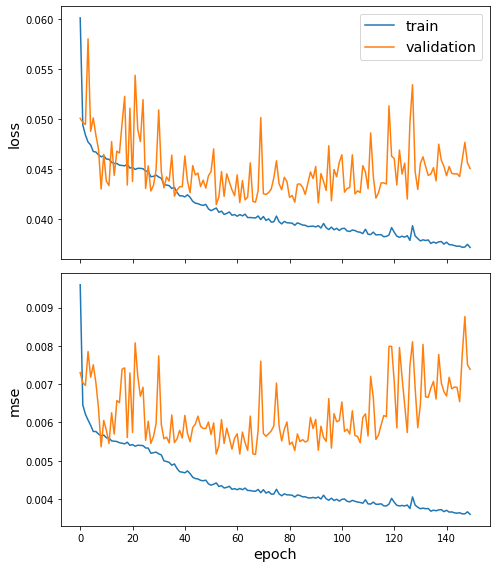

In [33]:
sg.utils.plot_history(history)


In [34]:
train_pred = model.predict(trainX)
test_pred= model.predict(testX) #predicting test set
mae  = MeanAbsoluteError()
testloss30 = mae(testY,test_pred).numpy()

In [35]:
print(train_pred.shape)
print(test_pred.shape)
print("Predicting values of first input of training data", train_pred[0,:])
print("Predicting values of first input of test data",test_pred[0,:])

print("Predicting values of random input (2000) of test data",test_pred[2000,:])

(56409, 8)
(12057, 8)
Predicting values of first input of training data [0.15856138 0.47519964 0.10238218 0.4234813  0.13066825 0.56508064
 0.12135487 0.5751831 ]
Predicting values of first input of test data [0.21628504 0.48303774 0.2461022  0.49187854 0.3054665  0.55759716
 0.66140234 0.5442882 ]
Predicting values of random input (2000) of test data [0.1327956  0.47641227 0.12041767 0.51294374 0.13021527 0.56896883
 0.23764683 0.57267004]


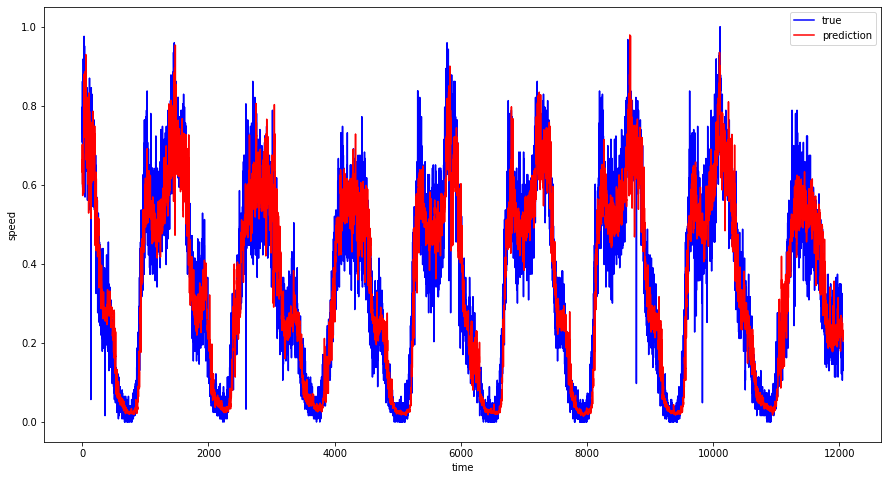

In [36]:
##all test result visualization
fig1 = plt.figure(figsize=(15, 8))
#    ax1 = fig1.add_subplot(1,1,1)
a_pred = test_pred[:, 6] #testing column 7, sensor 61 speed
a_true = testY[:, 6]#testing column 7, sensor 61 speed

plt.plot(a_true, "b-", label="true")
plt.plot(a_pred, "r-", label="prediction")
plt.xlabel("time")
plt.ylabel("speed")
plt.legend(loc="best", fontsize=10)
plt.show()

In [37]:

#converting predicitons and truths back into a data frame
test_preddf = pd.DataFrame(test_pred)
testY_df = pd.DataFrame(testY) 
#reversing scaling process to turn predictions and truths back into real units
testY_unscaled = pd.DataFrame(min_max_scaler.inverse_transform(testY_df))
print(test_preddf.head())
unscaledoutput = pd.DataFrame(min_max_scaler.inverse_transform(test_preddf))
#getting column names from the original dataset and converting real units into integers(volume only makes sense as an integer)
unscaledoutput.columns = dataset.columns
unscaledoutput = unscaledoutput.astype(int)
print(unscaledoutput.head())
testY_unscaled.columns=dataset.columns
testY_unscaled = testY_unscaled.astype(int)


print(testY_unscaled.head())



          0         1         2  ...         5         6         7
0  0.216285  0.483038  0.246102  ...  0.557597  0.661402  0.544288
1  0.204158  0.483207  0.238820  ...  0.560137  0.632142  0.547274
2  0.278707  0.481804  0.206651  ...  0.560809  0.634314  0.545837
3  0.147012  0.486004  0.265602  ...  0.561934  0.701990  0.543778
4  0.276510  0.480969  0.205216  ...  0.561339  0.659799  0.546774

[5 rows x 8 columns]
   010Volume  010Speed  032Volume  ...  045Speed  061Volume  061Speed
0         70        95         67  ...        97         81        91
1         66        95         65  ...        97         77        92
2         91        95         57  ...        97         78        92
3         48        96         73  ...        97         86        91
4         90        95         56  ...        97         81        92

[5 rows x 8 columns]
   010Volume  010Speed  032Volume  ...  045Speed  061Volume  061Speed
0         80        95         96  ...        97         90     

In [38]:
#saving truths and predictions to file for plotting later

unscaledoutput.to_csv('predictions/eb30minpred.csv')
testY_unscaled.to_csv('truths/eb30.csv')

Hyperparameter tuned for 30 min prediction. Will use same hyperparameter settings for all prediction lengths. Process will be repeated in each cell for each prediction length

In [39]:
seq_len = 10 #length of data used for the prediction, currently using the last 10 mins of data
pre_len = 5 # distance of prediction, currently predicting speeds and volumes 30 mins from now

#feature extractions using next prediction length
train5X, train5Y,val5X,val5Y, test5X, test5Y = sequence_data_preparation(
    seq_len, pre_len, train_data_t, val_data_t,test_data_t)

optimizer2=keras.optimizers.Adam(learning_rate=.01) #using tuned hyperparameters
gcn_lstm = GCN_LSTM(
    seq_len=seq_len,
    adj=corrmatrix,
    gc_layer_sizes=[16, 10],
    gc_activations=["relu", "relu"],
    lstm_layer_sizes=[200, 200],
    lstm_activations=["tanh", "tanh"],
    )# redefining model
x_input, x_output = gcn_lstm.in_out_tensors()
model = Model(inputs=x_input, outputs=x_output)
model.compile(optimizer=optimizer2, loss="mae", metrics=["mse"])
history = model.fit(
    train5X,
    train5Y,
    epochs=150,
    batch_size=200,
    shuffle=True,
    verbose=1,
    validation_data=(val5X, val5Y),
)#training model on new dataset with preselected hyperparameters
#saving training and validation loss at training completion
loss5 = history.history['val_loss'][149]
tloss5 = history.history['loss'][149]
model.save("EBmodels/eb5")
train_5pred = model.predict(train5X)
test_5pred= model.predict(test5X)
test5pred_t = test_5pred.transpose()
test_5preddf = pd.DataFrame(test_5pred)
testloss5=mae(test5Y,test_5pred).numpy()
print(test_5preddf.head())
unscaledoutput5 = pd.DataFrame(min_max_scaler.inverse_transform(test_5preddf))
unscaledoutput5.columns = dataset.columns
unscaledoutput5 = unscaledoutput5.astype(int)
print(unscaledoutput5.head())
unscaledoutput5.to_csv('predictions/eb5minpred.csv')
test5Y_df = pd.DataFrame(test5Y)
test5Y_unscaled = pd.DataFrame(min_max_scaler.inverse_transform(test5Y_df))
test5Y_unscaled.columns=dataset.columns
test5Y_unscaled = test5Y_unscaled.astype(int)
test5Y_unscaled.to_csv('truths/eb5.csv')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  from ipykernel import kernelapp as app


Epoch 1/150
283/283 [==============================] - 9s 20ms/step - loss: 0.0531 - mse: 0.0075 - val_loss: 0.0508 - val_mse: 0.0066
Epoch 2/150
283/283 [==============================] - 5s 16ms/step - loss: 0.0441 - mse: 0.0051 - val_loss: 0.0450 - val_mse: 0.0058
Epoch 3/150
283/283 [==============================] - 5s 16ms/step - loss: 0.0429 - mse: 0.0049 - val_loss: 0.0476 - val_mse: 0.0064
Epoch 4/150
283/283 [==============================] - 5s 16ms/step - loss: 0.0426 - mse: 0.0047 - val_loss: 0.0410 - val_mse: 0.0048
Epoch 5/150
283/283 [==============================] - 5s 16ms/step - loss: 0.0421 - mse: 0.0046 - val_loss: 0.0416 - val_mse: 0.0048
Epoch 6/150
283/283 [==============================] - 5s 16ms/step - loss: 0.0418 - mse: 0.0045 - val_loss: 0.0427 - val_mse: 0.0053
Epoch 7/150
283/283 [==============================] - 5s 16ms/step - loss: 0.0418 - mse: 0.0045 - val_loss: 0.0425 - val_mse: 0.0052
Epoch 8/150
283/283 [==============================] - 5s 16ms

INFO:tensorflow:Assets written to: EBmodels/eb5/assets


INFO:tensorflow:Assets written to: EBmodels/eb5/assets


          0         1         2  ...         5         6         7
0  0.206728  0.483771  0.237684  ...  0.561146  0.619662  0.552067
1  0.195917  0.484772  0.210618  ...  0.563923  0.651775  0.551836
2  0.193904  0.485741  0.251637  ...  0.561631  0.647846  0.550601
3  0.242274  0.485056  0.208656  ...  0.561648  0.632724  0.551658
4  0.246774  0.484462  0.226382  ...  0.562261  0.658202  0.550328

[5 rows x 8 columns]
   010Volume  010Speed  032Volume  ...  045Speed  061Volume  061Speed
0         67        95         65  ...        97         76        93
1         64        96         58  ...        98         80        93
2         63        96         69  ...        97         79        92
3         79        96         57  ...        97         77        93
4         80        96         62  ...        98         80        92

[5 rows x 8 columns]


In [40]:
seq_len = 10 #length of data used for the prediction, currently using the last 10 mins of data
pre_len = 10 # distance of prediction, currently predicting speeds and volumes 30 mins from now

train10X, train10Y,val10X,val10Y, test10X, test10Y = sequence_data_preparation(
    seq_len, pre_len, train_data_t, val_data_t,test_data_t)

optimizer2=keras.optimizers.Adam(learning_rate=.01)
gcn_lstm = GCN_LSTM(
    seq_len=seq_len,
    adj=corrmatrix,
    gc_layer_sizes=[16, 10],
    gc_activations=["relu", "relu"],
    lstm_layer_sizes=[200, 200],
    lstm_activations=["tanh", "tanh"],
    )
x_input, x_output = gcn_lstm.in_out_tensors()
model = Model(inputs=x_input, outputs=x_output)
model.compile(optimizer=optimizer2, loss="mae", metrics=["mse"])
history = model.fit(
    train10X,
    train10Y,
    epochs=150,
    batch_size=200,
    shuffle=True,
    verbose=1,
    validation_data=(val10X, val10Y),
)
loss10 = history.history['val_loss'][149]
tloss10 = history.history['loss'][149]
model.save("EBmodels/eb10")
train_10pred = model.predict(train10X)
test_10pred= model.predict(test10X)
testloss10=mae(test10Y,test_10pred).numpy()
test10pred_t = test_10pred.transpose()
test_10preddf = pd.DataFrame(test_10pred)
print(test_10preddf.head())
unscaledoutput10 = pd.DataFrame(min_max_scaler.inverse_transform(test_10preddf))
unscaledoutput10.columns = dataset.columns
unscaledoutput10 = unscaledoutput10.astype(int)
print(unscaledoutput10.head())
unscaledoutput10.to_csv('predictions/eb10minpred.csv')
test10Y_df = pd.DataFrame(test10Y)
test10Y_unscaled = pd.DataFrame(min_max_scaler.inverse_transform(test10Y_df))
test10Y_unscaled.columns=dataset.columns
test10Y_unscaled = test10Y_unscaled.astype(int)
test10Y_unscaled.to_csv('truths/eb10.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  


Epoch 1/150
283/283 [==============================] - 9s 20ms/step - loss: 0.0583 - mse: 0.0092 - val_loss: 0.0481 - val_mse: 0.0064
Epoch 2/150
283/283 [==============================] - 5s 16ms/step - loss: 0.0457 - mse: 0.0055 - val_loss: 0.0459 - val_mse: 0.0059
Epoch 3/150
283/283 [==============================] - 5s 16ms/step - loss: 0.0442 - mse: 0.0051 - val_loss: 0.0461 - val_mse: 0.0062
Epoch 4/150
283/283 [==============================] - 5s 16ms/step - loss: 0.0436 - mse: 0.0050 - val_loss: 0.0457 - val_mse: 0.0059
Epoch 5/150
283/283 [==============================] - 5s 16ms/step - loss: 0.0434 - mse: 0.0050 - val_loss: 0.0423 - val_mse: 0.0053
Epoch 6/150
283/283 [==============================] - 5s 16ms/step - loss: 0.0432 - mse: 0.0049 - val_loss: 0.0428 - val_mse: 0.0053
Epoch 7/150
283/283 [==============================] - 5s 16ms/step - loss: 0.0429 - mse: 0.0048 - val_loss: 0.0433 - val_mse: 0.0055
Epoch 8/150
283/283 [==============================] - 5s 16ms

INFO:tensorflow:Assets written to: EBmodels/eb10/assets


INFO:tensorflow:Assets written to: EBmodels/eb10/assets


          0         1         2  ...         5         6         7
0  0.289144  0.480112  0.203903  ...  0.558761  0.591688  0.549692
1  0.247613  0.481816  0.216097  ...  0.559417  0.595810  0.552243
2  0.161412  0.484601  0.270411  ...  0.559004  0.608492  0.554136
3  0.314478  0.478945  0.200326  ...  0.555105  0.619886  0.543858
4  0.194650  0.484212  0.253674  ...  0.557891  0.651389  0.545191

[5 rows x 8 columns]
   010Volume  010Speed  032Volume  ...  045Speed  061Volume  061Speed
0         94        95         56  ...        97         72        92
1         81        95         59  ...        97         73        93
2         52        96         74  ...        97         74        93
3        103        94         55  ...        97         76        91
4         63        96         70  ...        97         80        92

[5 rows x 8 columns]


In [41]:
seq_len = 10 #length of data used for the prediction, currently using the last 10 mins of data
pre_len = 15 # distance of prediction, currently predicting speeds and volumes 30 mins from now

train15X, train15Y,val15X,val15Y, test15X, test15Y = sequence_data_preparation(
    seq_len, pre_len, train_data_t, val_data_t,test_data_t)

optimizer2=keras.optimizers.Adam(learning_rate=.01)
gcn_lstm = GCN_LSTM(
    seq_len=seq_len,
    adj=corrmatrix,
    gc_layer_sizes=[16, 10],
    gc_activations=["relu", "relu"],
    lstm_layer_sizes=[200, 200],
    lstm_activations=["tanh", "tanh"],
    )
x_input, x_output = gcn_lstm.in_out_tensors()
model = Model(inputs=x_input, outputs=x_output)
model.compile(optimizer=optimizer2, loss="mae", metrics=["mse"])
history = model.fit(
    train15X,
    train15Y,
    epochs=150,
    batch_size=200,
    shuffle=True,
    verbose=1,
    validation_data=(val15X, val15Y),
)
loss15 = history.history['val_loss'][149]
tloss15 = history.history['loss'][149]
model.save("EBmodels/eb15")
train_15pred = model.predict(train15X)
test_15pred= model.predict(test15X)
testloss15=mae(test15Y,test_15pred).numpy()
test15pred_t = test_15pred.transpose()
test_15preddf = pd.DataFrame(test_15pred)
print(test_15preddf.head())
unscaledoutput15 = pd.DataFrame(min_max_scaler.inverse_transform(test_15preddf))
unscaledoutput15.columns = dataset.columns
unscaledoutput15 = unscaledoutput15.astype(int)
print(unscaledoutput15.head())
unscaledoutput15.to_csv('predictions/eb15minpred.csv')
test15Y_df = pd.DataFrame(test15Y)
test15Y_unscaled = pd.DataFrame(min_max_scaler.inverse_transform(test15Y_df))
test15Y_unscaled.columns=dataset.columns
test15Y_unscaled = test15Y_unscaled.astype(int)
test15Y_unscaled.to_csv('truths/eb15.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  


Epoch 1/150
283/283 [==============================] - 9s 20ms/step - loss: 0.0566 - mse: 0.0085 - val_loss: 0.0475 - val_mse: 0.0059
Epoch 2/150
283/283 [==============================] - 5s 16ms/step - loss: 0.0454 - mse: 0.0054 - val_loss: 0.0412 - val_mse: 0.0048
Epoch 3/150
283/283 [==============================] - 5s 16ms/step - loss: 0.0443 - mse: 0.0051 - val_loss: 0.0430 - val_mse: 0.0055
Epoch 4/150
283/283 [==============================] - 5s 16ms/step - loss: 0.0438 - mse: 0.0050 - val_loss: 0.0449 - val_mse: 0.0059
Epoch 5/150
283/283 [==============================] - 5s 16ms/step - loss: 0.0434 - mse: 0.0049 - val_loss: 0.0414 - val_mse: 0.0049
Epoch 6/150
283/283 [==============================] - 5s 16ms/step - loss: 0.0436 - mse: 0.0049 - val_loss: 0.0430 - val_mse: 0.0052
Epoch 7/150
283/283 [==============================] - 5s 16ms/step - loss: 0.0430 - mse: 0.0048 - val_loss: 0.0408 - val_mse: 0.0049
Epoch 8/150
283/283 [==============================] - 5s 16ms

INFO:tensorflow:Assets written to: EBmodels/eb15/assets


INFO:tensorflow:Assets written to: EBmodels/eb15/assets


          0         1         2  ...         5         6         7
0  0.237601  0.482603  0.250338  ...  0.553085  0.636460  0.546561
1  0.291196  0.480901  0.208223  ...  0.555134  0.608693  0.546296
2  0.128220  0.486017  0.285622  ...  0.552827  0.670492  0.545905
3  0.253112  0.482166  0.204588  ...  0.556594  0.636937  0.546604
4  0.221535  0.483960  0.228271  ...  0.555216  0.652386  0.546223

[5 rows x 8 columns]
   010Volume  010Speed  032Volume  ...  045Speed  061Volume  061Speed
0         77        95         69  ...        96         78        92
1         95        95         57  ...        97         74        92
2         42        96         78  ...        96         82        92
3         83        95         56  ...        97         78        92
4         72        95         63  ...        97         80        92

[5 rows x 8 columns]


In [42]:
seq_len = 10 #length of data used for the prediction, currently using the last 10 mins of data
pre_len = 45 # distance of prediction, currently predicting speeds and volumes 30 mins from now

train45X, train45Y,val45X,val45Y, test45X, test45Y = sequence_data_preparation(
    seq_len, pre_len, train_data_t, val_data_t,test_data_t)

optimizer2=keras.optimizers.Adam(learning_rate=.01)
gcn_lstm = GCN_LSTM(
    seq_len=seq_len,
    adj=corrmatrix,
    gc_layer_sizes=[16, 10],
    gc_activations=["relu", "relu"],
    lstm_layer_sizes=[200, 200],
    lstm_activations=["tanh", "tanh"],
    )
x_input, x_output = gcn_lstm.in_out_tensors()
model = Model(inputs=x_input, outputs=x_output)
model.compile(optimizer=optimizer2, loss="mae", metrics=["mse"])
history = model.fit(
    train45X,
    train45Y,
    epochs=150,
    batch_size=200,
    shuffle=True,
    verbose=1,
    validation_data=(val45X, val45Y),
)
loss45 = history.history['val_loss'][149]
tloss45 = history.history['loss'][149]
model.save("EBmodels/eb45")
train_45pred = model.predict(train45X)
test_45pred= model.predict(test45X)
testloss45=mae(test45Y,test_45pred).numpy()
test45pred_t = test_45pred.transpose()
test_45preddf = pd.DataFrame(test_45pred)
print(test_45preddf.head())
unscaledoutput45 = pd.DataFrame(min_max_scaler.inverse_transform(test_45preddf))
unscaledoutput45.columns = dataset.columns
unscaledoutput45 = unscaledoutput45.astype(int)
print(unscaledoutput45.head())
unscaledoutput45.to_csv('predictions/eb45minpred.csv')
test45Y_df = pd.DataFrame(test45Y)
test45Y_unscaled = pd.DataFrame(min_max_scaler.inverse_transform(test45Y_df))
test45Y_unscaled.columns=dataset.columns
test45Y_unscaled = test45Y_unscaled.astype(int)
test45Y_unscaled.to_csv('truths/eb45.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  


Epoch 1/150
282/282 [==============================] - 9s 20ms/step - loss: 0.0661 - mse: 0.0115 - val_loss: 0.0559 - val_mse: 0.0091
Epoch 2/150
282/282 [==============================] - 4s 16ms/step - loss: 0.0538 - mse: 0.0078 - val_loss: 0.0502 - val_mse: 0.0074
Epoch 3/150
282/282 [==============================] - 5s 16ms/step - loss: 0.0527 - mse: 0.0074 - val_loss: 0.0535 - val_mse: 0.0077
Epoch 4/150
282/282 [==============================] - 5s 16ms/step - loss: 0.0522 - mse: 0.0073 - val_loss: 0.0466 - val_mse: 0.0062
Epoch 5/150
282/282 [==============================] - 5s 16ms/step - loss: 0.0516 - mse: 0.0071 - val_loss: 0.0505 - val_mse: 0.0071
Epoch 6/150
282/282 [==============================] - 5s 16ms/step - loss: 0.0511 - mse: 0.0070 - val_loss: 0.0470 - val_mse: 0.0063
Epoch 7/150
282/282 [==============================] - 4s 16ms/step - loss: 0.0509 - mse: 0.0069 - val_loss: 0.0531 - val_mse: 0.0080
Epoch 8/150
282/282 [==============================] - 5s 16ms

INFO:tensorflow:Assets written to: EBmodels/eb45/assets


INFO:tensorflow:Assets written to: EBmodels/eb45/assets


          0         1         2  ...         5         6         7
0  0.231459  0.479171  0.248856  ...  0.556684  0.654884  0.545468
1  0.220686  0.479116  0.236820  ...  0.557408  0.635601  0.546886
2  0.221039  0.479740  0.235472  ...  0.556414  0.652301  0.544228
3  0.227498  0.480053  0.236703  ...  0.557467  0.637151  0.546455
4  0.230097  0.479975  0.229723  ...  0.555098  0.651905  0.545118

[5 rows x 8 columns]
   010Volume  010Speed  032Volume  ...  045Speed  061Volume  061Speed
0         75        95         68  ...        97         80        92
1         72        95         65  ...        97         78        92
2         72        95         64  ...        97         80        91
3         74        95         65  ...        97         78        92
4         75        95         63  ...        97         80        92

[5 rows x 8 columns]


In [43]:
seq_len = 10 #length of data used for the prediction, currently using the last 10 mins of data
pre_len = 60 # distance of prediction, currently predicting speeds and volumes 30 mins from now

train60X, train60Y,val60X,val60Y, test60X, test60Y = sequence_data_preparation(
    seq_len, pre_len, train_data_t, val_data_t,test_data_t)

optimizer2=keras.optimizers.Adam(learning_rate=.01)
gcn_lstm = GCN_LSTM(
    seq_len=seq_len,
    adj=corrmatrix,
    gc_layer_sizes=[16, 10],
    gc_activations=["relu", "relu"],
    lstm_layer_sizes=[200, 200],
    lstm_activations=["tanh", "tanh"],
    )
x_input, x_output = gcn_lstm.in_out_tensors()
model = Model(inputs=x_input, outputs=x_output)
model.compile(optimizer=optimizer2, loss="mae", metrics=["mse"])
history = model.fit(
    train60X,
    train60Y,
    epochs=150,
    batch_size=200,
    shuffle=True,
    verbose=1,
    validation_data=(val60X, val60Y),
)
loss60 = history.history['val_loss'][149]
tloss60 = history.history['loss'][149]
model.save("EBmodels/eb60")
train_60pred = model.predict(train60X)
test_60pred= model.predict(test60X)
testloss60=mae(test60Y,test_60pred).numpy()
test60pred_t = test_60pred.transpose()
test_60preddf = pd.DataFrame(test_60pred)
print(test_60preddf.head())
unscaledoutput60 = pd.DataFrame(min_max_scaler.inverse_transform(test_60preddf))
unscaledoutput60.columns = dataset.columns
unscaledoutput60 = unscaledoutput60.astype(int)
print(unscaledoutput60.head())
unscaledoutput60.to_csv('predictions/eb60minpred.csv')
test60Y_df = pd.DataFrame(test60Y)
test60Y_unscaled = pd.DataFrame(min_max_scaler.inverse_transform(test60Y_df))
test60Y_unscaled.columns=dataset.columns
test60Y_unscaled = test60Y_unscaled.astype(int)
test60Y_unscaled.to_csv('truths/eb60.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  


Epoch 1/150
282/282 [==============================] - 9s 20ms/step - loss: 0.0640 - mse: 0.0108 - val_loss: 0.0538 - val_mse: 0.0086
Epoch 2/150
282/282 [==============================] - 5s 16ms/step - loss: 0.0571 - mse: 0.0088 - val_loss: 0.0535 - val_mse: 0.0087
Epoch 3/150
282/282 [==============================] - 5s 16ms/step - loss: 0.0563 - mse: 0.0085 - val_loss: 0.0537 - val_mse: 0.0078
Epoch 4/150
282/282 [==============================] - 5s 16ms/step - loss: 0.0557 - mse: 0.0084 - val_loss: 0.0536 - val_mse: 0.0084
Epoch 5/150
282/282 [==============================] - 5s 16ms/step - loss: 0.0550 - mse: 0.0081 - val_loss: 0.0551 - val_mse: 0.0089
Epoch 6/150
282/282 [==============================] - 5s 16ms/step - loss: 0.0546 - mse: 0.0080 - val_loss: 0.0521 - val_mse: 0.0079
Epoch 7/150
282/282 [==============================] - 5s 16ms/step - loss: 0.0544 - mse: 0.0079 - val_loss: 0.0532 - val_mse: 0.0078
Epoch 8/150
282/282 [==============================] - 5s 16ms

INFO:tensorflow:Assets written to: EBmodels/eb60/assets


INFO:tensorflow:Assets written to: EBmodels/eb60/assets


          0         1         2  ...         5         6         7
0  0.200205  0.480257  0.223314  ...  0.555240  0.579723  0.544594
1  0.188585  0.480538  0.221194  ...  0.554988  0.557079  0.545997
2  0.303528  0.482953  0.279425  ...  0.529334  0.854604  0.502029
3  0.253560  0.482742  0.269215  ...  0.539911  0.795629  0.507832
4  0.217812  0.480952  0.253874  ...  0.552005  0.627460  0.536461

[5 rows x 8 columns]
   010Volume  010Speed  032Volume  ...  045Speed  061Volume  061Speed
0         65        95         61  ...        97         71        91
1         61        95         61  ...        97         68        92
2         99        95         77  ...        93        105        84
3         83        95         74  ...        94         97        85
4         71        95         70  ...        96         77        90

[5 rows x 8 columns]


In [45]:
#these arent used in a coding environmnent again. 
#they are used to construct comparitive visualisations in excel for the report

losses_per_model = [loss5,loss10,loss15,loss30,loss45,loss60]
with open("model_performances/eb_val_losses_time.txt", "w") as outfile:
    outfile.write("\n".join(str(item) for item in losses_per_model))
tlosses_per_model = [tloss5,tloss10,tloss15,tloss30,tloss45,tloss60]
with open("model_performances/eb_train_losses_time.txt", "w") as outfile:
    outfile.write("\n".join(str(item) for item in tlosses_per_model))
test_losses_per_model = [testloss5,testloss10,testloss15,testloss30,testloss45,testloss60]
with open("model_performances/eb_test_losses_time.txt", "w") as outfile:
    outfile.write("\n".join(str(item) for item in tlosses_per_model))  


In [46]:
#google colab only supports the downloading of individual files. 
#If running in colab, compresses all outputs into a zip to be imported
#!zip -r /content/file.zip /content


  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/.last_update_check.json (deflated 22%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2021.10.08/ (stored 0%)
  adding: content/.config/logs/2021.10.08/13.45.08.864173.log (deflated 54%)
  adding: content/.config/logs/2021.10.08/13.44.44.548229.log (deflated 86%)
  adding: content/.config/logs/2021.10.08/13.44.50.952139.log (deflated 53%)
  adding: content/.config/logs/2021.10.08/13.44.27.879250.log (deflated 54%)
  adding: content/.config/logs/2021.10.08/13.45.09.534390.log (deflated 53%)
  adding: content/.config/logs/2021.10.08/13.44.08.162145.log (deflated 91%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/.last